```bash
Nasdaq Time Series Analysis
```

In [12]:
# Libraries
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn import metrics
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import seaborn as sns
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [13]:
# Load in the data "
data = pd.read_csv('../multiple_regression/merged_data.csv')
data.rename(columns={'CPALWE01USQ661N': 'CPI', 'S&P 500 ^GSPC': 'S&P_500', 'NASDAQ ^IXIC': 'NASDAQ', 'Dow Jones ^DJI':'Dow_Jones', 'RealInterestRate':'Real_IR', 'UnemploymentRate': 'Unemployment_Rate', 'FedFundsRate': 'Federal_Funds_Rate'}, inplace = True)
dates = data['Date']
data.head(10)

,Date,S&P_500,NASDAQ,Dow_Jones,CPI,Real_IR,Unemployment_Rate,GDP_Growth,M2_Supply,Federal_Funds_Rate
0,1992-01-01,408.779999,620.210022,3223.399902,58.870052,3.198542,7.3,4.9,3398.6,4.03
1,1992-04-01,414.950012,578.679993,3359.100098,59.387717,3.789860,7.4,4.4,3434.1,3.73
2,1992-07-01,424.209991,580.830017,3393.800049,59.862244,3.353099,7.7,4.0,3407.1,3.25
3,1992-10-01,418.679993,605.169983,3226.300049,60.279252,2.728044,7.3,4.2,3413.8,3.10
4,1993-01-01,438.779999,696.340027,3310.000000,60.696260,3.267908,7.3,0.7,3455.2,3.02
5,1993-04-01,440.190002,661.419983,3427.550049,61.185166,2.774517,7.1,2.3,3438.6,2.96
6,1993-07-01,448.130005,704.700012,3539.469971,61.415239,2.591799,6.9,1.9,3450.7,3.06
7,1993-10-01,467.829987,779.260010,3680.590088,61.832248,2.398843,6.8,5.6,3449.1,2.99
8,1994-01-01,481.609985,800.469971,3978.360107,62.119840,2.772685,6.6,3.9,3502.8,3.05
9,1994-04-01,450.910004,733.840027,3681.689941,62.551227,3.659183,6.4,5.5,3507.2,3.56


In [15]:
# lagged features
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore', category = UserWarning)
warnings.filterwarnings('ignore', category = ConvergenceWarning)
warnings.filterwarnings('ignore')  


data['NASDAQ_Diff'] = data['NASDAQ'].diff()

data = data.dropna() #drops first row with NA values due to differencing

In [16]:
# defining independent and dependent variables for lasso-ARIMAX
independent_variables = ['CPI', 'Real_IR', 'Unemployment_Rate', 'GDP_Growth', 'M2_Supply', 'Federal_Funds_Rate', 'NASDAQ_Diff']
dependent_variable = ['NASDAQ_Diff']

x = data[independent_variables].iloc[0:-1]
y = data[dependent_variable].iloc[1:]

In [17]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, shuffle = False)

dates = dates.iloc[y_test.index]

In [18]:
# Transform x values into standard normal (mean = 0, std = 1)
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [19]:
# running lasso with 5 folds on training set
lasso = LassoCV(cv = 5, random_state = 42)
lasso.fit(x_train_scaled, y_train.to_numpy().ravel()) # asked generative ai about ravel to supress warning
optimal_lambda = lasso.alpha_
coefficient = lasso.coef_

In [20]:
# predicting the data with the test set
y_pred = lasso.predict(x_test_scaled)
rmse = (mean_squared_error(y_test, y_pred)) ** 0.5
mse = rmse ** 2
print(f'Test RMSE: {rmse:.2f}')
print(f'Optimal Lambda: {optimal_lambda:.2f}')
for i in range(len(x.columns)):
    variable = x.columns[i]
    coef = coefficient[i]
    print(f'{variable}: {coef:.2f}')

Test RMSE: 1102.88
Optimal Lambda: 5.37
CPI: -0.00
Real_IR: -21.49
Unemployment_Rate: 15.27
GDP_Growth: 83.13
M2_Supply: 32.61
Federal_Funds_Rate: -0.00
NASDAQ_Diff: 12.09


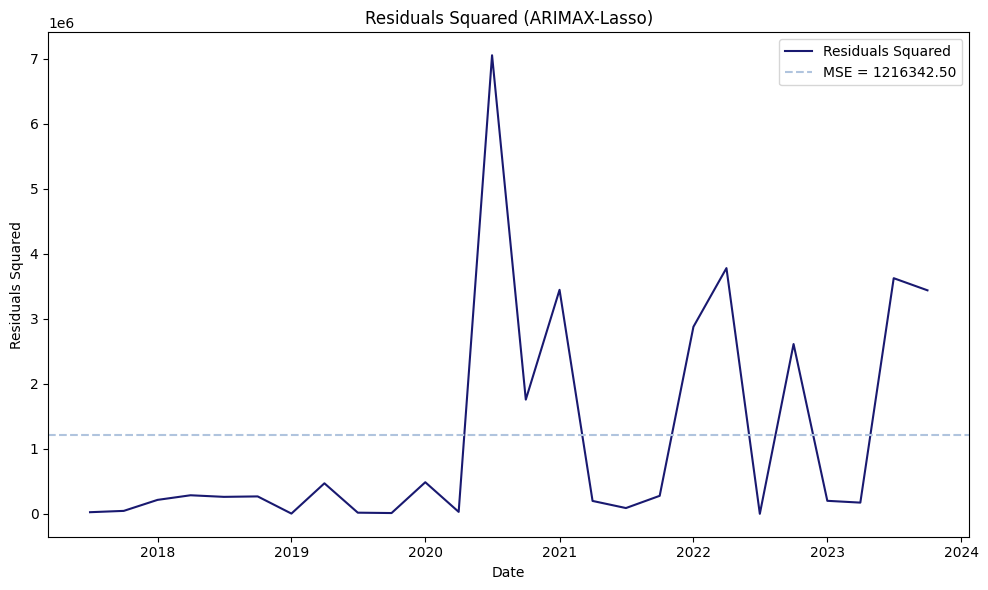

In [21]:
y_test_series =  y_test.squeeze() # convert to series, to calculate residuals
residuals_squared = (y_test_series - y_pred) ** 2

plt.figure(figsize=(10, 6))
plt.plot(pd.to_datetime(dates), residuals_squared, color = 'midnightblue', label = 'Residuals Squared')
plt.axhline(y = rmse**2, color = 'lightsteelblue', linestyle = '--', label = f'MSE = {rmse**2:.2f}')
plt.xlabel('Date')
plt.ylabel('Residuals Squared')
plt.title('Residuals Squared (ARIMAX-Lasso)')
plt.legend()
plt.tight_layout()
plt.show()

```bash
n this Time-Series Lasso model, we aimed to predict the quarterly change in the Nasdaq index (t) using prior values of macroeconomic indicators and the previous quarter’s Nasdaq change (t−1). By differencing the target variable, we ensured the time series was stationary, and by aligning the predictors to one period behind, we preserved temporal causality.

This structure allowed the model to evaluate not just current macroeconomic impact, but how past trends shape future changes in market performance.

The model produced a Test RMSE of 1102.88, which is reasonable considering the scale and volatility of the Nasdaq. The optimal regularization strength (λ = 5.37) helped shrink unimportant features while maintaining interpretability.

Coefficient Interpretation:
GDP_Growth = 83.13: This was the strongest macroeconomic predictor — economic expansion in the prior quarter was associated with notable Nasdaq increases, likely due to optimism in the tech-heavy index.

NASDAQ_Diff (t−1) = 12.09: Indicates some momentum, meaning previous growth in the index may lead to continued upward movement.

Unemployment_Rate = 15.27: A modest positive effect — possibly because the tech sector can rebound quickly even in soft labor markets.

M2_Supply = 32.61: Suggests that increased liquidity supports Nasdaq performance, consistent with broader equity trends.

Real_IR = −21.49: Indicates that rising real interest rates have a dampening effect on Nasdaq, likely due to discounting of future earnings in tech-heavy sectors.

CPI and Federal_Funds_Rate = 0.00: Lasso drove these coefficients to zero, implying they added little predictive power when other variables were considered.

This model shows that for the Nasdaq, GDP growth, prior performance, and M2 supply are key predictors of future movements. Unlike the Dow, there is some evidence of momentum, and the negative impact of interest rates is more pronounced — reflecting the Nasdaq’s sensitivity to future earnings expectations.
```

In [23]:
data = {
    'Model': ['MLR', 'Standard Lasso', 'ARIMAX-style Lasso'],
    'Test RMSE': [2846.65, 3158.26, 1102.88],
    'Optimal Lambda': ['N/A', 5.1, 5.37],
    'Top Predictors': [
        'M2_Supply, Unemployment_Rate, GDP_Growth',
        'M2_Supply, Unemployment_Rate, GDP_growth',
        'M2_Supply, GDP_Growth, NASDAQ_Diff'
    ],
    'Differenced Series': ['No', 'No', 'Yes']
}

comparison_df = pd.DataFrame(data)

comparison_df

,Model,Test RMSE,Optimal Lambda,Top Predictors,Differenced Series
0,MLR,2846.65,N/A,"M2_Supply, Unemployment_Rate, GDP_Growth",No
1,Standard Lasso,3158.26,5.1,"M2_Supply, Unemployment_Rate, GDP_growth",No
2,ARIMAX-style Lasso,1102.88,5.37,"M2_Supply, GDP_Growth, NASDAQ_Diff",Yes
